# Iris Dataset

The iris species dataset is one of the most popular examples for trying predictive modeling. It contains 50 examples of each species, and the goal is to classify the species correctly based on sepal and petal data.

In [35]:
# Import libraries

# Data
from sklearn import datasets

# Stats
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    accuracy_score,
)

# DataFrame
import pandas as pd
import numpy as np

# Plots
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [36]:
# Load dataset
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

<IPython.core.display.Javascript object>

In [37]:
# See data
iris_df = pd.DataFrame(iris["data"], columns=iris["feature_names"])
iris_df["target"] = iris["target"]

print("Targets: ", [(i, iris) for i, iris in enumerate(iris["target_names"])])
print("Number of Records: ", iris_df.shape[0])
iris_df.head()

Targets:  [(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]
Number of Records:  150


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


<IPython.core.display.Javascript object>

There are 4 features (sepal length, sepal width, petal length, petal width) that seem pretty distinct. There are 3 possible targets, which are 0 (setosa), 1 (versicolor), and 2 (virginica).

# Explore Dataset

#### How many records do we have of each target? 

In [38]:
# Plot distribution of targets
iris_df.groupby("target").count().iloc[:, 0]

target
0    50
1    50
2    50
Name: sepal length (cm), dtype: int64

<IPython.core.display.Javascript object>

#### What's the distribution of each variable against each target?

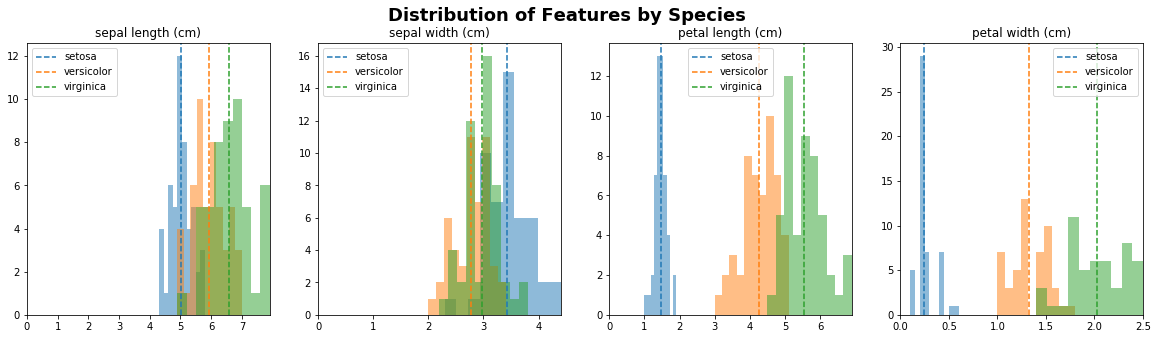

<IPython.core.display.Javascript object>

In [39]:
# Plot distribution for all 4 features

num_features = len(iris["feature_names"])
targets = np.arange(len(iris_df.target.unique()))
cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, axes = plt.subplots(1, num_features, figsize=[20, 5])
fig.suptitle("Distribution of Features by Species", fontsize=18, fontweight="bold")

for i, ax in enumerate(axes):

    ax.set_xlim([0, iris_df.iloc[:, i].max()])
    ax.set_title(iris["feature_names"][i])

    for target in targets:

        ax.hist(
            iris_df[iris_df.target == target].iloc[:, i], color=cycle[target], alpha=0.5
        )
        ax.axvline(
            iris_df[iris_df.target == target].iloc[:, i].mean(),
            color=cycle[target],
            alpha=1,
            linestyle="--",
        )

    ax.legend(iris["target_names"])

All distributions follow normal curve.

Observations:
* Sepal Length: Setosa < Versicolor < Virginia
* Sepal Width: Versicolor < Virginica < Setosa
* Petal Length: Setosa (<2cm) < Versicolor < Virginica
* Petal Width: Setosa < Versicolor < Virginica

It seems easy to tell what is `setosa` due to its non-overlapping petal length and petal width.

#### Are these features correlated?

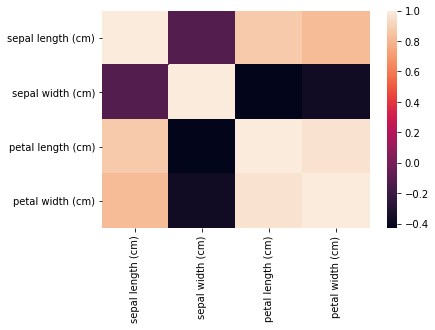

<IPython.core.display.Javascript object>

In [40]:
# Plot correlations
sns.heatmap(iris_df.iloc[:, :-1].corr())

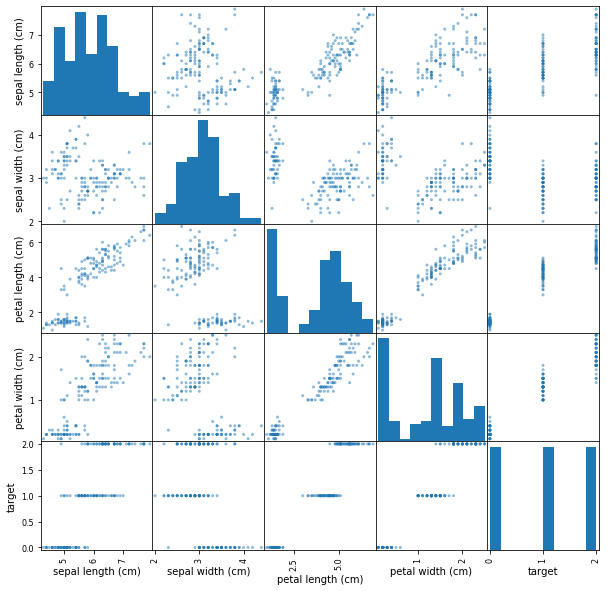

<IPython.core.display.Javascript object>

In [61]:
scatter_matrix(iris_df, figsize=[10, 10])

Observations:
* Sepal width has the least correlation with other features
* Petal Length and Petal Width are highly correlated
* Sepal Length and Petal Length are correlated

# Logistic Regression (for 1 species)

Predict Virginica by Petal Width

In [51]:
# Set up data
X = iris["data"][:, 3:]  # Petal Width
y = (iris["target"] == 2).astype(np.int)  # 1 if Virginia, else 0

# Set up Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Probability')

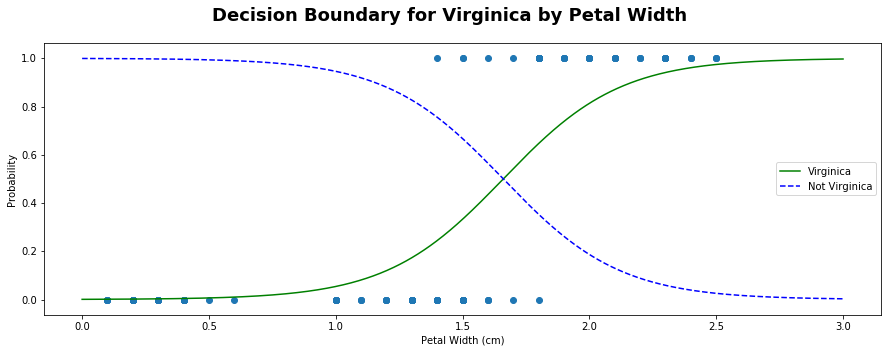

<IPython.core.display.Javascript object>

In [52]:
# Plot Decision Boundary
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_prob = log_reg.predict_proba(X_new)

fig, ax = plt.subplots(figsize=[15, 5])
fig.suptitle(
    "Decision Boundary for Virginica by Petal Width", fontsize=18, fontweight="bold"
)

ax.plot(X_new, y_prob[:, 1], "g-", label="True")
ax.plot(X_new, y_prob[:, 0], "b--", label="False")
ax.legend(["Virginica", "Not Virginica"])

ax.scatter(X, y)

ax.set_xlabel("Petal Width (cm)")
ax.set_ylabel("Probability")

In [53]:
# Calculate scores
ps = round(precision_score(y, log_reg.predict(X)), 2)
rs = round(recall_score(y, log_reg.predict(X)), 2)
f1 = round(f1_score(y, log_reg.predict(X)), 2)

print(f"Precision: {ps}")
print(f"Recall: {rs}")
print(f"F1: {f1}")

confusion_matrix(y, log_reg.predict(X))

Precision: 0.96
Recall: 0.92
F1: 0.94


array([[98,  2],
       [ 4, 46]])

<IPython.core.display.Javascript object>

Petal width alone generates a decent f1 score for Virginica.

Predict Virginica by other features (all features seems to perform the best)

In [54]:
# Set up data
X = iris["data"]  # All features
y = (iris["target"] == 2).astype(np.int)  # 1 if Virginia, else 0

# Set up Log Reg
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

# Print Scores
ps = round(precision_score(y, log_reg.predict(X)), 2)
rs = round(recall_score(y, log_reg.predict(X)), 2)
f1 = round(f1_score(y, log_reg.predict(X)), 2)

print(f"Precision: {ps}")
print(f"Recall: {rs}")
print(f"F1: {f1}")

confusion_matrix(y, log_reg.predict(X))

Precision: 0.94
Recall: 0.98
F1: 0.96


array([[97,  3],
       [ 1, 49]])

<IPython.core.display.Javascript object>

Predict for Versicolor...which doesn't do so great

In [55]:
# Set up data
X = iris["data"]  # All features
y = (iris["target"] == 1).astype(np.int)  # 1 if Versicolor, else 0

# Set up Log Reg
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

# Print Scores
ps = round(precision_score(y, log_reg.predict(X)), 2)
rs = round(recall_score(y, log_reg.predict(X)), 2)
f1 = round(f1_score(y, log_reg.predict(X)), 2)

print(f"Precision: {ps}")
print(f"Recall: {rs}")
print(f"F1: {f1}")

confusion_matrix(y, log_reg.predict(X))

Precision: 0.64
Recall: 0.42
F1: 0.51


array([[88, 12],
       [29, 21]])

<IPython.core.display.Javascript object>

Predict for Setosa (which is easy because of petal length/width)

In [56]:
# Set up data
X = iris["data"]  # All features
y = (iris["target"] == 0).astype(np.int)  # 1 if Setosa, else 0

# Set up Log Reg
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

# Print Scores
ps = round(precision_score(y, log_reg.predict(X)), 2)
rs = round(recall_score(y, log_reg.predict(X)), 2)
f1 = round(f1_score(y, log_reg.predict(X)), 2)

print(f"Precision: {ps}")
print(f"Recall: {rs}")
print(f"F1: {f1}")

confusion_matrix(y, log_reg.predict(X))

Precision: 1.0
Recall: 1.0
F1: 1.0


array([[100,   0],
       [  0,  50]])

<IPython.core.display.Javascript object>

If doing a binary classifier for 1 species at a time, setosa is very easy to predict due to its petal length and width. Virginica also does fairly well in predictions because its sepal length, petal length, and petal width averages the highest of the 3 irises. Versicolor does not perform that well because its features are similar of the other two flowers' features. 

# Multiclass Prediction

In [59]:
# Set up data
X = iris["data"]  # All features
y = iris["target"]

# Create + fit model
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X, y)
y_preds = sgd_clf.predict(X)

print(f"Accuracy is {round(100*accuracy_score(y_preds, y), 1)}%")

# Confusion matrix
confusion_matrix(y, y_preds)

Accuracy is 93.3%


array([[50,  0,  0],
       [ 2, 46,  2],
       [ 0,  6, 44]])

<IPython.core.display.Javascript object>

With the SGD Classifier (one-versus-all), setosa has high accuracy, but versicolor/virginica perform worse. The model incorrectly classifies some versicolors as setosas. However, petal length and petal width should be the giveaway for what is and isn't setosa. 

A one-versus-one approach might work better for reducing the number of flowers misclassified as setosa.

In [60]:
# Set up data
X = iris["data"]  # All features
y = iris["target"]

# Create + fit model
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X, y)
y_preds = ovo_clf.predict(X)

print(f"Accuracy is {round(100*accuracy_score(y_preds, y), 1)}%")

# Confusion matrix
confusion_matrix(y, y_preds)

Accuracy is 98.7%


array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  0, 50]])

<IPython.core.display.Javascript object>

The one-versus-one method did clear the "fake" setosas and increased the accuracy between versicolor and virginica!